In [1]:
import os

import time

import numpy as np

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

2024-12-19 15:45:28.015282: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 15:45:29.578556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 15:45:29.578581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 15:45:29.590534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 15:45:30.100775: I tensorflow/core/platform/cpu_feature_g

In [2]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 16  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 24  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea


In [3]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [7]:
N = 1000

# covariates = tf.expand_dims(tfp.distributions.Normal(loc = 0.0, scale = 1).sample(N), axis = -1)
# np.save("Data/HMC/covariates.npy", covariates)

covariates = tf.convert_to_tensor(np.load("Data/HMC/covariates.npy"))

In [8]:
SIS = logistic_SIS(covariates)

parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
	      "log_beta":tf.math.log(tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_I":tf.convert_to_tensor([+0.3], dtype = tf.float32),
              "b_S":tf.convert_to_tensor([-0.3], dtype = tf.float32),
	      "log_gamma":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([+0.2], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),}

tf.Tensor(15.777, shape=(), dtype=float32)
tf.Tensor(9.34, shape=(), dtype=float32)


(array([0.07253732, 0.03820896, 0.01880597, 0.01089552, 0.0038806 ,
        0.00179104, 0.00134328, 0.00104478, 0.00044776, 0.00029851]),
 array([ 0.        ,  6.69999981, 13.39999962, 20.10000038, 26.79999924,
        33.5       , 40.20000076, 46.90000153, 53.59999847, 60.29999924,
        67.        ]),
 <BarContainer object of 10 artists>)

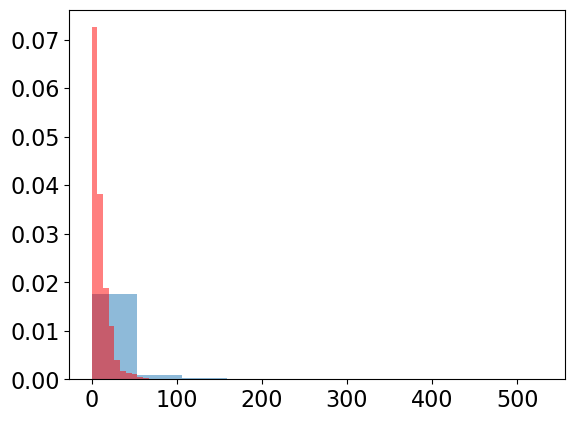

In [32]:
covariates =  tf.expand_dims(tfp.distributions.Normal(loc = 0.0, scale = 5).sample(N), axis = -1)

print(tf.reduce_mean(tfp.distributions.Geometric( probs = 1-tf.math.exp(-tf.math.exp(parameters["log_gamma"] + covariates*parameters["b_R"])[:,0])).sample()))
print(tf.reduce_mean(tfp.distributions.Geometric( probs = 1-tf.math.exp(-tf.math.exp(parameters["log_gamma"][0]))).sample(1000)))

plt.hist(tfp.distributions.Geometric( probs = 1-tf.math.exp(-tf.math.exp(parameters["log_gamma"] + covariates*parameters["b_R"])[:,0])).sample(), density = True, alpha = 0.5)
plt.hist(tfp.distributions.Geometric( probs = 1-tf.math.exp(-tf.math.exp(parameters["log_gamma"][0]))).sample(1000), color = "red", density = True, alpha = 0.5)

In [59]:
T    = 200
# start = time.time()
# X, Y = simulator(SIS, parameters, T)
# print(time.time()-start)

# X, Y = X[:,0,...], Y[:,0,...]
# np.save("Data/HMC/X.npy", X)
# np.save("Data/HMC/Y.npy", Y)

X = tf.convert_to_tensor(np.load("Data/HMC/X.npy"))
Y = tf.convert_to_tensor(np.load("Data/HMC/Y.npy"))

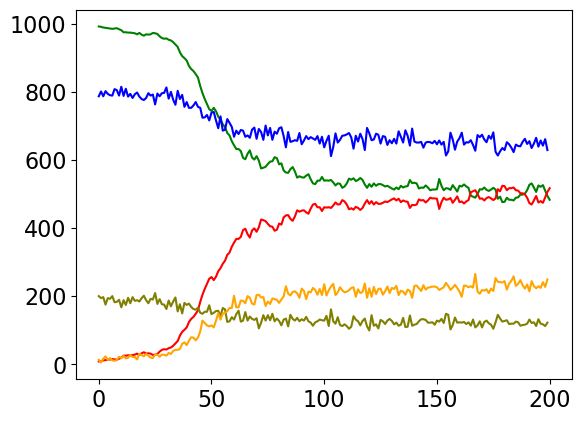

In [60]:
plt.plot(tf.reduce_sum(X, axis = 1 )[:,0], color = "green")
plt.plot(tf.reduce_sum(X, axis = 1 )[:,1], color = "red")

plt.plot(tf.reduce_sum(Y, axis = 1 )[:,0], color = "blue")
plt.plot(tf.reduce_sum(Y, axis = 1 )[:,1], color = "olive")
plt.plot(tf.reduce_sum(Y, axis = 1 )[:,2], color = "orange")

In [61]:
os.chdir("Scripts/")
%run -i CAL.py
%run -i CAL_without_correction.py
os.chdir("../")

In [62]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

The time lap is  0.9666833877563477
The log-likelihood is  -149682.73


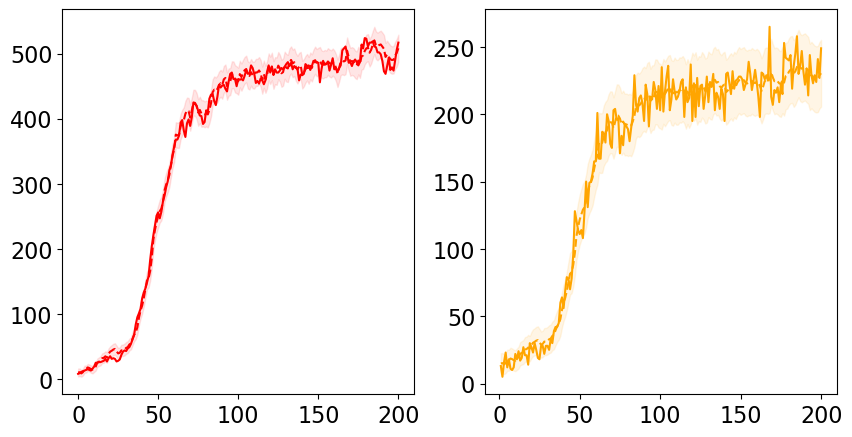

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [64]:
tfd = tfp.distributions

# loss_list = []
# parameters_list = []

# for i in range(10):
# 	parameters_vector_HMC = tf.convert_to_tensor([np.log(0.2), 0.3, -0.3, np.log(0.1), 0.2, logit(0.2), logit(0.5)], dtype = tf.float32)
# 	parameters_vector_HMC = parameters_vector_HMC + tfd.Normal(loc = 0.0, scale = 1.0).sample(tf.shape(parameters_vector_HMC))

# 	parameters_HMC = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
# 		"log_beta":parameters_vector_HMC[0:1],
# 		"b_I":parameters_vector_HMC[1:2],
# 		"b_S":parameters_vector_HMC[2:3],
# 		"log_gamma":parameters_vector_HMC[3:4],
# 		"b_R":parameters_vector_HMC[4:5],
# 		"logit_sensitivity": tf.convert_to_tensor([logit(0.9)], dtype = tf.float32), #parameters_vector_HMC[5:6],
# 		"logit_specificity": tf.convert_to_tensor([logit(0.95)], dtype = tf.float32), #parameters_vector_HMC[6:7],
# 		"logit_prob_testing":parameters_vector_HMC[5:7],}

# 	n_gradient_steps = 2000
# 	learning_parameters = {"log_beta":1, "b_I":1, "b_S":1, 
# 			"log_gamma":1,"b_R":1, 
# 			"logit_prob_testing":2, }

# 	optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

# 	loss_tensor, parameters_tensor = CAL_inference(SIS, parameters_HMC, Y, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

# 	loss_list.append(loss_tensor)
# 	parameters_list.append(parameters_tensor)

In [65]:
# fig, ax = plt.subplots(1, 6, figsize = (30, 5))

# for i in range(10):
# 	k = 0
# 	for key in parameters_list[i].keys():

# 		if tf.shape(parameters[key])==1:
# 			ax[k].plot(parameters_list[i][key], color = "blue")
# 			ax[k].axhline(parameters[key], color = "red")

# 			# if k==1:
# 			# 	ax[k].plot(-parameters_tensor[key], color = "green")

# 		else:
# 			for i in range(tf.shape(parameters[key])[0]):
# 				ax[k].plot(parameters_list[i][key][:,i], color = "blue")
# 				ax[k].axhline(parameters[key][i], color = "red")

# 		k = k+1


In [66]:
# best_index = tf.math.argmax(tf.stack(loss_list)[:,-1])

# parameters_tensor = parameters_list[best_index]

# fig, ax = plt.subplots(1, 6, figsize = (30, 5))

# k = 0
# for key in parameters_tensor.keys():

# 	if tf.shape(parameters[key])==1:
# 		ax[k].plot(parameters_tensor[key], color = "blue")
# 		ax[k].axhline(parameters[key], color = "red")

# 	else:
# 		for i in range(tf.shape(parameters[key])[0]):
# 			ax[k].plot(parameters_tensor[key][:,i], color = "blue")
# 			ax[k].axhline(parameters[key][i], color = "red")

# 	k = k+1

In [67]:
# parameters_vector_HMC = tf.convert_to_tensor([parameters_tensor["log_beta"][-1,0],
#                                               parameters_tensor["b_I"][-1,0], parameters_tensor["b_S"][-1,0],
#                                		      parameters_tensor["log_gamma"][-1,0], parameters_tensor["b_R"][-1,0],
# 					      parameters_tensor["logit_prob_testing"][-1,0], parameters_tensor["logit_prob_testing"][-1,1]], dtype = tf.float32)

parameters_vector_HMC = tf.convert_to_tensor(np.load("Data/HMC/parameters_init.npy"), dtype = tf.float32)

parameter_dim = tf.shape(parameters_vector_HMC)[0]

def prior_fn():
    
    return tfd.MultivariateNormalDiag(loc=tf.zeros([parameter_dim]), scale_diag=100*tf.ones([parameter_dim]))

def log_likelihood_fn(parameters_vector_HMC):

	parameters_HMC = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
		"log_beta":parameters_vector_HMC[0:1],
		"b_I":parameters_vector_HMC[1:2],
		"b_S":parameters_vector_HMC[2:3],
		"log_gamma":parameters_vector_HMC[3:4],
		"b_R":parameters_vector_HMC[4:5],
		"logit_sensitivity": tf.convert_to_tensor([logit(0.9)], dtype = tf.float32), #parameters_vector_HMC[5:6],
		"logit_specificity": tf.convert_to_tensor([logit(0.95)], dtype = tf.float32), #parameters_vector_HMC[6:7],
		"logit_prob_testing":parameters_vector_HMC[5:7],}

	_, _, log_likelihood = CAL(SIS, parameters_HMC, Y)

	return log_likelihood

def joint_log_prob_fn(parameters_vector_HMC):
    
    prior = prior_fn().log_prob(parameters_vector_HMC)
    likelihood = log_likelihood_fn(parameters_vector_HMC)
    
    return prior + likelihood

In [68]:
@tf.function
def run_hmc(initial_state):
    
    # Create the HMC kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob_fn,
        step_size=0.1,
        num_leapfrog_steps=10)
    
    # Wrap the HMC kernel with an adaptation kernel for tuning step size
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=1000,  
        target_accept_prob=0.65)
    
    # Run the MCMC chain
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=10000,  # Number of posterior samples
        num_burnin_steps=1000,  # Burn-in steps
        current_state=initial_state,
        kernel=adaptive_kernel,
        trace_fn=lambda _, pkr: pkr)  # Trace kernel results for diagnostics
    
    return samples, kernel_results


In [69]:
# np.save("Data/HMC/parameters_init.npy", parameters_vector_HMC)

In [70]:
# samples, kernel_results = run_hmc(parameters_vector_HMC)

In [71]:
# # Convert the samples to numpy for further analysis
# posterior_samples = samples.numpy()

# np.save("Data/HMC/posterior_new.npy", posterior_samples)

# # Check acceptance rate
# acceptance_rate = kernel_results.inner_results.is_accepted.numpy().mean()
# print("Acceptance rate:", acceptance_rate)

In [72]:
parameters

{'prior_infection': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99, 0.01], dtype=float32)>,
 'log_beta': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.609438], dtype=float32)>,
 'b_I': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>,
 'b_S': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3], dtype=float32)>,
 'log_gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.3025851], dtype=float32)>,
 'b_R': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>,
 'logit_sensitivity': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.1972244], dtype=float32)>,
 'logit_specificity': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.9444387], dtype=float32)>,
 'logit_prob_testing': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3862944,  0.       ], dtype=float32)>}

array([-1.40833431, -1.37980469])

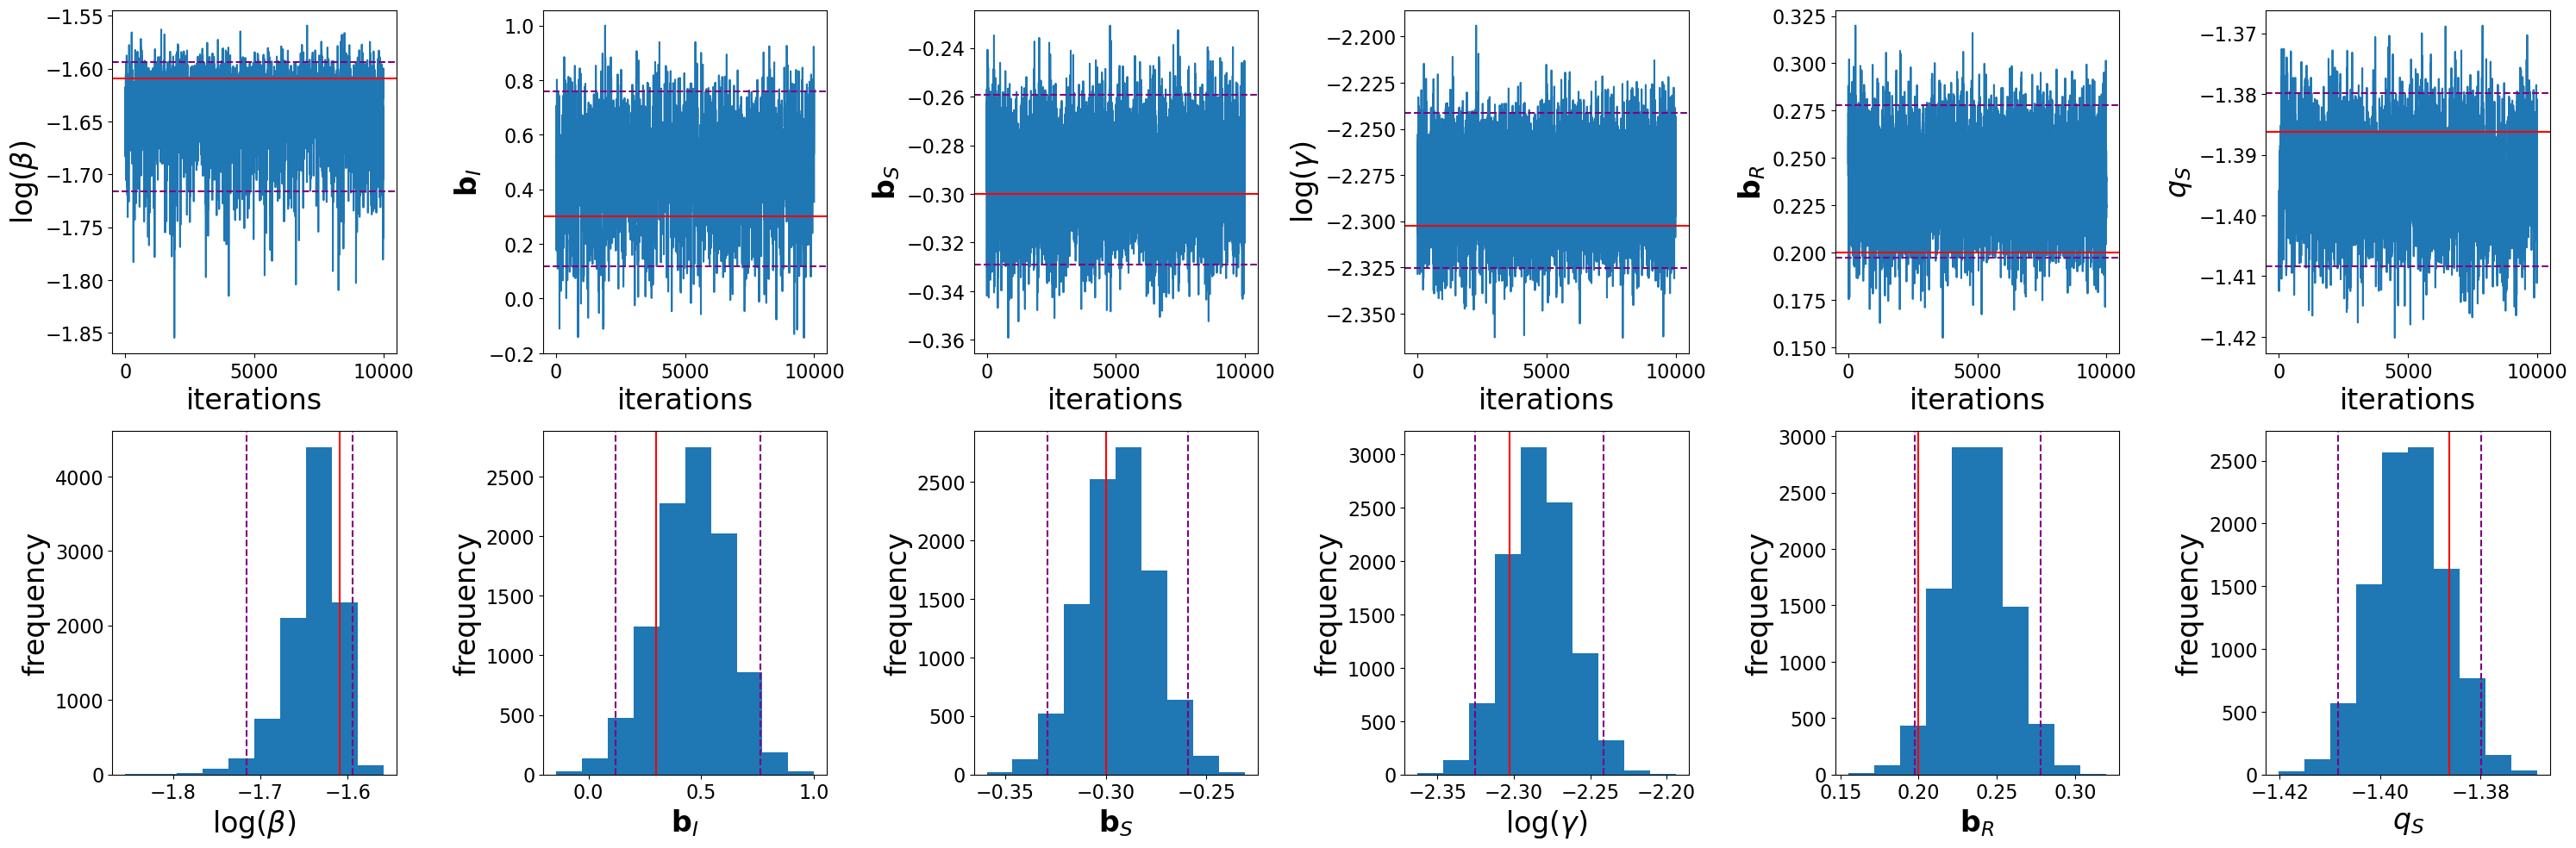

In [79]:
posterior_samples = np.load("Data/HMC/posterior_new.npy")
parameters_vector_HMC_true = tf.convert_to_tensor([np.log(0.2), 0.3, -0.3, np.log(0.1), 0.2, logit(0.2), logit(0.5)], dtype = tf.float32)

names_list =  [r"$\log(\beta)$", r"$\mathbf{b}_I$", r"$\mathbf{b}_S$", r"$\log(\gamma)$", r"$\mathbf{b}_R$",
	       r"$q_S$", r"$q_I$"]
 
fig, ax = plt.subplots(2, 6, figsize = (30, 10))

for k in range(6):

	quantiles = np.quantile(posterior_samples[:,k], [0.025, 0.975])

	ax[0,k].set_xlabel("iterations")
	ax[0,k].set_ylabel(names_list[k])
	ax[0,k].plot(posterior_samples[:,k])
	ax[0,k].axhline(parameters_vector_HMC_true[k], color = "red")
	ax[0,k].axhline(quantiles[0], color = "purple", linestyle = "--")
	ax[0,k].axhline(quantiles[1], color = "purple", linestyle = "--")

	ax[1,k].set_xlabel(names_list[k])
	ax[1,k].set_ylabel("frequency")
	ax[1,k].hist(posterior_samples[:,k])
	ax[1,k].axvline(parameters_vector_HMC_true[k], color = "red")
	ax[1,k].axvline(quantiles[0], color = "purple", linestyle = "--")
	ax[1,k].axvline(quantiles[1], color = "purple", linestyle = "--")

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()
plt.savefig('Figures/HMC.png', format='png', dpi=100, bbox_inches='tight')

In [74]:
parameters

{'prior_infection': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99, 0.01], dtype=float32)>,
 'log_beta': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.609438], dtype=float32)>,
 'b_I': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>,
 'b_S': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3], dtype=float32)>,
 'log_gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.3025851], dtype=float32)>,
 'b_R': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>,
 'logit_sensitivity': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.1972244], dtype=float32)>,
 'logit_specificity': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.9444387], dtype=float32)>,
 'logit_prob_testing': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3862944,  0.       ], dtype=float32)>}